In [28]:
import pandas as pd
df=pd.read_csv('Desktop/Reel/Housing.csv')
df.head(2)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [29]:
print(df.isin([0]).any())


price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad            False
guestroom           False
basement            False
hotwaterheating     False
airconditioning     False
parking              True
prefarea            False
furnishingstatus    False
dtype: bool


In [30]:
print('parking',df['parking'].mean())
df['parking']=df['parking'].replace(0,df['parking'].mean())


parking 0.6935779816513762


In [31]:
print(df.isin([0]).any())


price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad            False
guestroom           False
basement            False
hotwaterheating     False
airconditioning     False
parking             False
prefarea            False
furnishingstatus    False
dtype: bool


In [32]:
df.isnull().sum()


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [33]:
# Fixed cell: encode categorical features (yes/no mapping + get_dummies) then 10-fold CV (test_size=0.10)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Prepare data (assumes df is already loaded and cleaned)
X = df.drop('price', axis=1).copy()
y = df['price'].copy()

# 1) Detect object/categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

# 2) Map common yes/no columns to 1/0 (case-insensitive)
yes_no_vals = {'yes': 1, 'no': 0, 'Yes': 1, 'No': 0, 'YES':1, 'NO':0, 'Y':1, 'N':0}
mapped = []
for col in cat_cols:
    unique_vals = set(X[col].dropna().unique())
    # if all values are subset of yes/no variants, map them
    if unique_vals and unique_vals.issubset(set(yes_no_vals.keys())):
        X[col] = X[col].map(yes_no_vals)
        mapped.append(col)

# Update list of categorical columns after mapping
cat_cols_remaining = [c for c in cat_cols if c not in mapped]
print("Columns mapped to 0/1:", mapped)
print("Remaining categorical columns to one-hot encode:", cat_cols_remaining)

# 3) One-hot encode remaining categorical columns (drop_first to avoid collinearity)
if len(cat_cols_remaining) > 0:
    X = pd.get_dummies(X, columns=cat_cols_remaining, drop_first=True)

# 4) Final sanity check: ensure all columns are numeric
try:
    X = X.astype(float)
except Exception as e:
    # show any problematic columns
    bad = [col for col in X.columns if not np.issubdtype(X[col].dtype, np.number)]
    raise ValueError(f"Non-numeric columns remain after encoding: {bad}") from e

print("Final feature matrix shape (after encoding):", X.shape)

# Train-test split (keeping 10% for hold-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Build list of regression models
models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor(random_state=42)))
models.append(('RF', RandomForestRegressor(n_estimators=100, random_state=42)))
models.append(('ADA', AdaBoostRegressor(n_estimators=100, random_state=42)))
models.append(('GB', GradientBoostingRegressor(n_estimators=100, random_state=42)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))

# Cross-validation setup
seed = 42
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = 'r2'   # R² used as accuracy metric for regression

# Evaluate each model using 10-fold CV on the training set
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})")


Categorical columns detected: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
Columns mapped to 0/1: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
Remaining categorical columns to one-hot encode: ['furnishingstatus']
Final feature matrix shape (after encoding): (545, 13)
LR: 0.641530 (0.059207)
DT: 0.264266 (0.184539)
RF: 0.627428 (0.063561)
ADA: 0.516763 (0.102266)
GB: 0.632002 (0.063387)
KNN: 0.304477 (0.134350)
SVR: -0.061915 (0.069949)


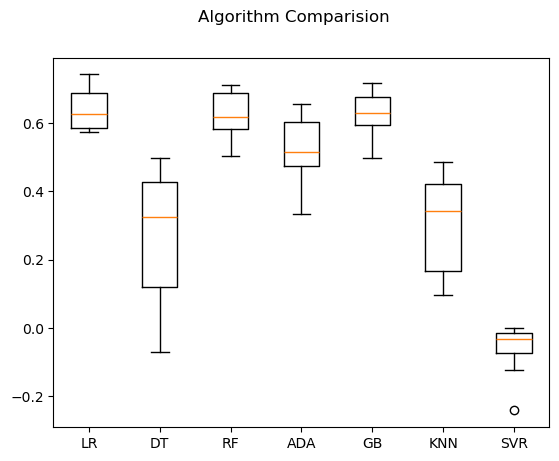

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Algorithm Comparision')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()